#FloPy

###Zonbud Example 1

This notebook demonstrates how to use the functions included in the zonbud utility to extract budget information from the cell by cell budget file using an array of zones.

First set the path and import the required packages. The flopy path doesn't have to be set if you install flopy from a binary installer. If you want to run this notebook, you have to set the path to your own flopy path.

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import platform
import flopy
import numpy as np
import matplotlib.pyplot as plt

#Set the paths
modelpath = os.path.join('..', 'data', 'freyberg')
zbudpath = os.path.join('..', 'data', 'zonbud_ex')

#make sure zbudpath directory exists
if not os.path.exists(zbudpath):
    os.makedirs(zbudpath)

###Create Some Zones and Extract Budget Information

We create a simple numpy integer-array to define some zones for which we are interested in getting cell-by-cell budget information.

In [2]:
# Define some very interesting zones
nrow, ncol = 40, 20
zon = np.zeros((1, nrow, ncol), np.int)  # note that we explicitly make this a 1-layer array
zon[0, :nrow/2, :ncol/2] = 1
zon[0, :nrow/2, ncol/2:] = 2
zon[0, nrow/2:, :ncol/2] = 3
zon[0, nrow/2:, ncol/2:] = 4

# Run ZoneBudget
cbc_file = os.path.join(modelpath, 'freyberg.gitcbc')
zb = flopy.utils.ZoneBudget(cbc_file)
print(zb.get_ssst_names())

['WELLS', 'RIVER LEAKAGE', 'RECHARGE']


In [3]:
print(zb.get_kstpkper())

[(0, 0)]


In [4]:
%%timeit
flopy.utils.zonbud.ZoneBudget(cbc_file)

1000 loops, best of 3: 1.72 ms per loop


###Get ZoneBudget Output

We use the `get_budget()` method of the zonebudget object to return a Budget object. The Budget object is a wrapper around a numpy recarray that can then be used to write the budget to a csv file. Let's look at the dtype:

In [5]:
zbud = zb.get_budget(zon, kstpkper=(0, 0))
print(zbud.array.dtype)
print(zbud.kstpkper)

[('flow_dir', 'S3'), ('record', 'S20'), ('ZONE   1', '<f8'), ('ZONE   2', '<f8'), ('ZONE   3', '<f8'), ('ZONE   4', '<f8')]
(0, 0)


E:\modflow\local_repo\flopy\flopy\utils\zonbud.py:264: UserWarning: CONSTANT HEAD cells were detected, but will not be included in the zonebudget results. Any non-zero results should be considered erroneous.
  warnings.warn(chwarn, UserWarning)


now let's look at all inflow terms:

In [6]:
print(zbud.array[zbud.array['flow_dir']=='in'])

[('in', 'CONSTANT HEAD', 0.0, 0.0, 0.0, 0.0)
 ('in', 'WELLS', 0.0, 0.0, 0.0, 0.0)
 ('in', 'RIVER LEAKAGE', 0.0, 0.004194190260022879, 0.0, 0.0)
 ('in', 'RECHARGE', 0.015300000726711005, 0.020000000949949026, 0.015900000755209476, 0.01830000086920336)
 ('in', 'FROM ZONE   1', 0.0, 0.013101870194077492, 0.0028348490595817566, 0.0)
 ('in', 'FROM ZONE   2', 0.0, 0.0, 0.0, 0.0012257143389433622)
 ('in', 'FROM ZONE   3', 0.0006367169553413987, 0.0, 0.0, 0.013000612147152424)
 ('in', 'FROM ZONE   4', 0.0, 0.0011461640242487192, 0.0, 0.0)]


all recharge:

In [7]:
print(zbud.array[zbud.array['record']=='RECHARGE'])

[ ('in', 'RECHARGE', 0.015300000726711005, 0.020000000949949026, 0.015900000755209476, 0.01830000086920336)
 ('out', 'RECHARGE', -0.0, -0.0, -0.0, -0.0)]


and zone 1 outflow:

In [8]:
z1_outflow = zbud.array['ZONE   1'][zbud.array['flow_dir'] == 'out']
print(z1_outflow)
print('Total Outflow from Zone 1 (kstpkper=(0, 0)): {out:.5f}'.format(out=z1_outflow.sum()*-1))

[-0.          0.          0.         -0.          0.          0.01310187
  0.00283485  0.        ]
Total Outflow from Zone 1 (kstpkper=(0, 0)): -0.01594


###Write ZoneBudget Output to CSV

We can write the resulting recarray to a csv with the .to_csv() method of the ZoneBudget object.

In [9]:
out_fname = os.path.join(zbudpath, 'zbud.csv')
zbud.to_csv(out_fname, format='pandas')

# Read the file in to see the contents
try:
    import pandas as pd
    df = pd.read_csv(out_fname)
    df = df.fillna(0)
    print(df.to_string(index=False))
except:
    with open(out_fname, 'r') as f:
        for line in f.readlines():
            print('\t'.join(line.split(',')))

flow_dir         record      ZONE   1      ZONE   2   ZONE   3  ZONE   4
      in  CONSTANT HEAD  0.000000e+00  0.000000e+00   0.000000  0.000000
      in          WELLS  0.000000e+00  0.000000e+00   0.000000  0.000000
      in  RIVER LEAKAGE  0.000000e+00  4.194190e-03   0.000000  0.000000
      in       RECHARGE  1.530000e-02  2.000000e-02   0.015900  0.018300
      in  FROM ZONE   1  0.000000e+00  1.310187e-02   0.002835  0.000000
      in  FROM ZONE   2  0.000000e+00  0.000000e+00   0.000000  0.001226
      in  FROM ZONE   3  6.367170e-04  0.000000e+00   0.000000  0.013001
      in  FROM ZONE   4  0.000000e+00  1.146164e-03   0.000000  0.000000
               Total IN  1.593672e-02  3.844223e-02   0.018735  0.032526
     out  CONSTANT HEAD -0.000000e+00 -0.000000e+00  -0.000000 -0.000000
     out          WELLS  0.000000e+00  1.620000e-02   0.001550  0.004300
     out  RIVER LEAKAGE  0.000000e+00  2.101684e-02   0.000000  0.025893
     out       RECHARGE -0.000000e+00 -0.000000e+00

###Plot Cell by Cell Budgets
Access and plot source/sink/storage budget terms.

C:\Anaconda\lib\site-packages\matplotlib\collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


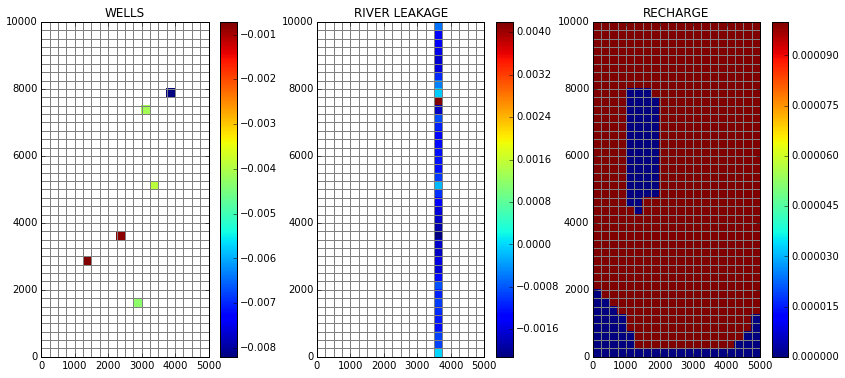

In [10]:
ml = flopy.modflow.Modflow.load(os.path.join(modelpath, 'freyberg.nam'), check=False)

names = zb.get_ssst_names()
zbud_arrays = [zb.get_ssst_cbc_array(name, kstpkper=(0, 0)) for name in names]
fig = plt.figure(figsize=(14, 6))

for idx, name in enumerate(names):
    zbud = zbud_arrays[idx][0, :, :]
    ax = fig.add_subplot(1, len(names), idx+1, aspect='equal')
    ax.set_title(name)
    modelmap = flopy.plot.ModelMap(model=ml)
    modelmap.plot_grid()
    quadmesh = modelmap.plot_array(zbud)
    cbar = fig.colorbar(quadmesh)
    
plt.show()